In [1]:
%matplotlib inline
from matplotlib import style ,figure
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import dateutil.relativedelta
import scipy.stats as stats

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func ,distinct

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station=Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
Measurement_db=session.query(Measurement).first()

#Checking the Columns on Measurement_db
Measurement_db.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x154b572f908>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0}

In [9]:
Station_db=session.query(Station).first()

#Checking the Columns on Measurement_db
Station_db.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x154b57ab0c8>,
 'id': 1,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'longitude': -157.8168,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data
Data_date=session.query(Measurement.date)

# Calculate the date 1 year ago from the last data point in the database
Max_date=dt.datetime.strptime(max(Data_date)[0],'%Y-%m-%d')
Min_date=dt.datetime.strptime(min(Data_date)[0],'%Y-%m-%d')
#print(Max_date)
# print(Min_date)
Last_year=Max_date-dt.timedelta(days=365)
Last_year_date=Last_year.strftime('%Y-%m-%d')
print(f"Last year point is : {Last_year_date}")


Last year point is : 2016-08-23


### Precipitation Analysis

In [11]:
# Perform a query to retrieve the data and precipitation scores

prcp_list=[Measurement.date,Measurement.prcp]
Data_prcp = session.query(*prcp_list).filter(Measurement.date > Last_year_date).all()

In [12]:

# Save the query results as a Pandas DataFrame and set the index to the date column
Data_prcp_df=pd.DataFrame(Data_prcp)
# Sort the dataframe by date
Data_prcp_df=Data_prcp_df.sort_values("date")
Data_prcp_df=Data_prcp_df.dropna(how='any')
Data_prcp_df=Data_prcp_df.rename(columns={"prcp": "Precipitation"})
Data_prcp_df.tail(5)

,date,Precipitation
1522,2017-08-22,0.00
1523,2017-08-23,0.08
359,2017-08-23,0.00
1005,2017-08-23,0.00
2222,2017-08-23,0.45


## NOTE: As you see the "date" column is not unique, so it does not make sense to set it as an index! So, I just group by the data frame and using the average of "Precipitation" for plotting.

In [13]:
Data_prcp_group_df=Data_prcp_df.groupby(['date']).agg({'date':'max','Precipitation':'mean'})
Data_prcp_group_df=Data_prcp_group_df.set_index('date')
Data_prcp_group_df

,Precipitation
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


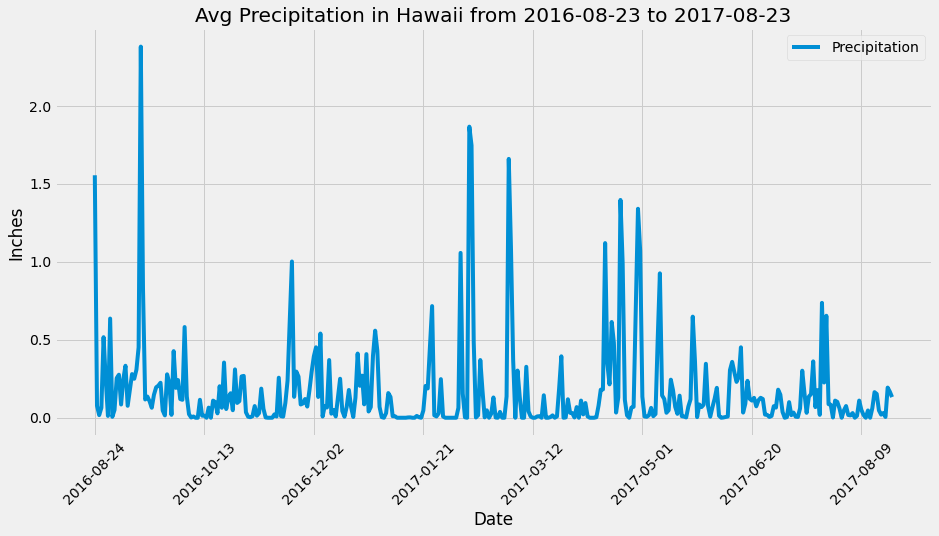

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data

rain_plot = Data_prcp_group_df.plot(figsize = (14, 7),rot=45)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title(f"Avg Precipitation in Hawaii from {Last_year_date} to {max(Data_date)[0]}")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#1.For all Stations precipitation in evry day 
Data_prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#2.For average of precipitation in evry day 
Data_prcp_group_df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [17]:
# Design a query to show how many stations are available in this dataset?
Station_data = session.query(func.count(distinct(Measurement.station))).all()
print(f" There are {Station_data[0][0]} unique Stations in 'Mesearment' dataset")

There are 9 unique Stations in 'Mesearment' dataset


# Station Analysis

## I did this part in 2 Ways : 
1. just with session.query 
2. with session.query and DataFrames

### 1. Just with session.query

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Station_data = session.query(Measurement.station,Station.name,func.count(Measurement.tobs))\
                                    .filter(Measurement.station == Station.station)\
                                    .group_by(Measurement.station,Station.name)\
                                    .order_by(func.count(Measurement.tobs).desc()).all()
Station_data

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [19]:
# Choose the station with the highest number of temperature observations.
MAX_row=0
MAX_id=""
for i in range (0,len(Station_data)-1):
    if Station_data[i][2] > MAX_row :
        MAX_row=Station_data[i][2]
        MAX_id=Station_data[i][0]
print(MAX_id,' : ', MAX_row)

USC00519281  :  2772


In [20]:
# Design a query to show the max , min , avg data of station wih the highest number of temperature observations
Measurement_data3 = session.query(Measurement.station,Station.name,
                                  func.count(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.min(Measurement.tobs),
                                  func.avg(Measurement.tobs))\
                                    .filter(Measurement.station == Station.station)\
                                    .filter(Measurement.station == MAX_id)\
                                    .group_by(Measurement.station,Station.name)\
                                    .all()

print (f""" \nThe station with the highest number of temperature observations is:\n
          Station ID : {Measurement_data3[0][0]}
          Station Name : {Measurement_data3[0][1]}
          number of observations : {Measurement_data3[0][2]}
          Minimum temperature recorded : {Measurement_data3[0][3]}
          Maximum temperature recorded : {Measurement_data3[0][4]}
          Average temperature recorded : {Measurement_data3[0][5]} """)


The station with the highest number of temperature observations is:

          Station ID : USC00519281
          Station Name : WAIHEE 837.5, HI US
          number of observations : 2772
          Minimum temperature recorded : 85.0
          Maximum temperature recorded : 54.0
          Average temperature recorded : 71.66378066378067 


### 2. with session.query and DataFrames

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

Measurement_list=[Measurement.id,Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs,Station.name]
Measurement_data = session.query(*Measurement_list).filter(Measurement.station == Station.station).all()
Measurement_df=pd.DataFrame(Measurement_data)
Measurement_df
Measurement_df=Measurement_df.set_index("id")
Num_Station=Measurement_df.groupby(["station"]).agg({'station':'max','name':'max','date':'count'})
Num_Station=Num_Station.rename(columns={"date":"Number_of_Data","name":"Station_Name"})
Num_Station.sort_values("Number_of_Data",ascending=False)
Num_Station=Num_Station.set_index("station")
Num_Station.sort_values("Number_of_Data",ascending=False)

,Station_Name,Number_of_Data
station,,
USC00519281,"WAIHEE 837.5, HI US",2772
USC00519397,"WAIKIKI 717.2, HI US",2724
USC00513117,"KANEOHE 838.1, HI US",2709
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
USC00517948,"PEARL CITY, HI US",1372
USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
Most_active_station_no=Num_Station.Number_of_Data.max()
#Most_active_station_no
Most_active_station_id=Num_Station.loc[Num_Station.Number_of_Data==Most_active_station_no].index.tolist()
#Most_active_station_id
Station_ST=pd.DataFrame(Measurement_df.groupby(["station"]).agg({'station':'max','name':'max','tobs':['min','max','mean','count']}))
Station_ST=Station_ST.reset_index(drop=True)
Station_ST.columns =['Station_id','station_name','Min_Temp','Max_Temp','Avg_Temp','Number_of_records']
#Station_ST=Station_ST.set_index('Station_id')
# Station_ST
Most_Active_Station_ST=Station_ST.loc[ Station_ST.Station_id.isin (Most_active_station_id)].values.tolist()

Most_Active_Station_ST
print (f""" \nThe station with the highest number of temperature observations is:\n
          Station ID : {Most_Active_Station_ST[0][0]}
          Station Name : {Most_Active_Station_ST[0][1]}
          number of observations : {Most_Active_Station_ST[0][5]}
          Minimum temperature recorded : {Most_Active_Station_ST[0][2]}
          Maximum temperature recorded : {Most_Active_Station_ST[0][3]}
          Average temperature recorded : {Most_Active_Station_ST[0][4]} """)



The station with the highest number of temperature observations is:

          Station ID : USC00519281
          Station Name : WAIHEE 837.5, HI US
          number of observations : 2772
          Minimum temperature recorded : 54.0
          Maximum temperature recorded : 85.0
          Average temperature recorded : 71.66378066378067 


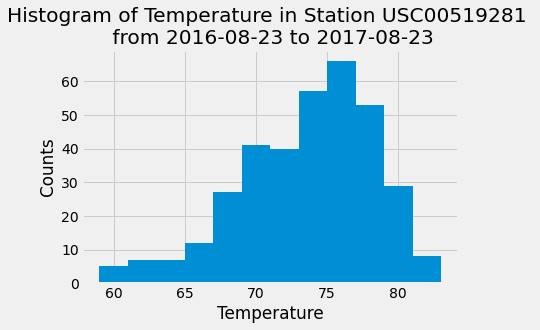

In [23]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Measurement_Station=[Measurement.id,Measurement.station,Measurement.date,Measurement.tobs]

Measurement_Station_data = session.query(*Measurement_Station).filter(Measurement.station == max(Most_active_station_id)).filter(Measurement.date >= Last_year_date).all()

Measurement_Station_df=pd.DataFrame(Measurement_Station_data)
Measurement_Station_df
plt.hist(Measurement_Station_df.tobs,bins=12)
plt.xlabel("Temperature")
plt.ylabel("Counts")
plt.title(f"Histogram of Temperature in Station {max(Most_active_station_id)} \n from {Last_year_date} to {max(Data_date)[0]}")
plt.show()

# Bonus Challenge Assignment

## Temperature Analysis I

In [34]:
# Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
# You may either use SQLAlchemy or pandas's read_csv() to perform this portion.
# Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.


Measurement_df
June_avg_temp=Measurement_df[Measurement_df['date'].str.slice(start=5, stop=7)=='06'].groupby(Measurement_df['station']).agg({'tobs':'mean'})
Dec_avg_temp=Measurement_df[Measurement_df['date'].str.slice(start=5, stop=7)=='12'].groupby(Measurement_df['station']).agg({'tobs':'mean'})

# Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

print(stats.ttest_ind(June_avg_temp['tobs'], Dec_avg_temp['tobs'], equal_var=False))


Ttest_indResult(statistic=4.615865424404701, pvalue=0.0003657335214469917)


 As the P_value is smaller than 0.5 so there is no significant difference between June and December tempratures

## Temperature Analysis II

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Getting Start and End of travel dates from user
K=True
while (K==True):
    Start_Date=input(" **Bonus part**: Start of your trip '%YYYY-%mm-%dd'")
    End_Date=input("End of your trip '%YYYY-%mm-%dd'")
    if (End_Date<Start_Date): 
        input(" Your Start day is greater than End day!! Try again (Enter)")
    else: K=False
# Start_Date='2017-08-01'
# End_Date='2017-08-05'

print (f"Your journey starts from {Start_Date} to {End_Date}")

Your journey starts from 2020-08-02 to 2020-08-15


In [27]:
#Converting the date to availabe date in data base
Start_date=str('2016'+Start_Date[-6:])
End_date=str('2016'+End_Date[-6:])
#print(Start_date,End_Date)

#Geting the data from calc_temps
Data =calc_temps(start_date=Start_date, end_date=End_date)
#convert data to data Frame
Trip_df1=pd.DataFrame(Data,columns=['tmin', 'tavg', 'tmax'])


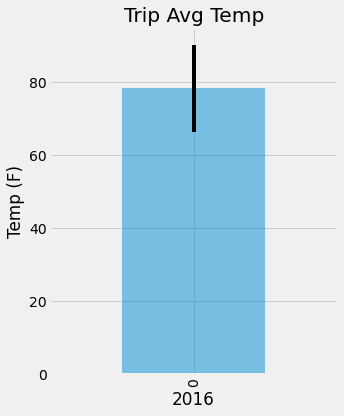

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
Trip_df1.plot.bar(figsize = (5, 6),y='tavg',yerr=(Trip_df1['tmax'] - Trip_df1['tmin']),title='Trip Avg Temp', alpha=0.5)
plt.ylabel("Temp (F)")
plt.xlabel("2016")
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()


In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# prcp_stations=[Measurement.date,Measurement.prcp,Measurement.station,Measurement.tobs]
# Data_prcp = session.query(*prcp_stations).filter(Measurement.date >= Last_year_date).all()

trip_rain_list=[Measurement.id,Measurement.date,Measurement.station,Measurement.prcp,Station.latitude,Station.longitude,Station.elevation]
Trip_rain=session.query(*trip_rain_list).filter(Measurement.date >= Start_date).filter(Measurement.date <= End_date).filter(Measurement.station==Station.station).all()

Last_year_data_df=pd.DataFrame(Trip_rain)

# # Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prcp_stations_df_group=Last_year_data_df.groupby(['station']).agg(
                {'station':'max','prcp':'sum','latitude':'max','longitude':'max','elevation':'max'})
prcp_stations_df_group.sort_values('prcp',ascending=False)




,station,prcp,latitude,longitude,elevation
station,,,,,
USC00516128,USC00516128,5.60,21.33310,-157.80250,152.4
USC00519281,USC00519281,3.23,21.45167,-157.84889,32.9
USC00513117,USC00513117,2.00,21.42340,-157.80150,14.6
USC00514830,USC00514830,1.16,21.52130,-157.83740,7.0
USC00519523,USC00519523,0.78,21.33556,-157.71139,19.5
USC00519397,USC00519397,0.51,21.27160,-157.81680,3.0
USC00517948,USC00517948,0.18,21.39340,-157.97510,11.9


## Daily Rainfall Average

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip

normals_list=[]

for day in Last_year_data_df.date.unique():
   
     X=daily_normals(day[-5:])
     normals=[Start_Date[:5]+day[-5:],day[-5:],X[0][0],X[0][1],X[0][2]]
     normals_list.append(normals)
normals_list

[['2020-08-02', '08-02', 68.0, 75.60377358490567, 84.0],
 ['2020-08-03', '08-03', 70.0, 76.61111111111111, 85.0],
 ['2020-08-04', '08-04', 69.0, 76.71153846153847, 84.0],
 ['2020-08-05', '08-05', 69.0, 76.14814814814815, 82.0],
 ['2020-08-06', '08-06', 67.0, 76.25, 83.0],
 ['2020-08-07', '08-07', 71.0, 77.15686274509804, 83.0],
 ['2020-08-08', '08-08', 68.0, 76.5576923076923, 83.0],
 ['2020-08-09', '08-09', 69.0, 75.98039215686275, 81.0],
 ['2020-08-10', '08-10', 65.0, 76.42, 83.0],
 ['2020-08-11', '08-11', 67.0, 75.98113207547169, 82.0],
 ['2020-08-12', '08-12', 67.0, 76.52727272727273, 83.0],
 ['2020-08-13', '08-13', 71.0, 76.98245614035088, 84.0],
 ['2020-08-14', '08-14', 71.0, 76.77777777777777, 82.0],
 ['2020-08-15', '08-15', 69.0, 76.47169811320755, 83.0]]

In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Trip_daily_df=pd.DataFrame(normals_list,columns=['Date','trip_dates','min','avg', 'max'])
Trip_daily_df=Trip_daily_df.set_index('Date')
Trip_daily_df

,trip_dates,min,avg,max
Date,,,,
2020-08-02,08-02,68.0,75.603774,84.0
2020-08-03,08-03,70.0,76.611111,85.0
2020-08-04,08-04,69.0,76.711538,84.0
2020-08-05,08-05,69.0,76.148148,82.0
2020-08-06,08-06,67.0,76.250000,83.0
2020-08-07,08-07,71.0,77.156863,83.0
2020-08-08,08-08,68.0,76.557692,83.0
2020-08-09,08-09,69.0,75.980392,81.0
2020-08-10,08-10,65.0,76.420000,83.0


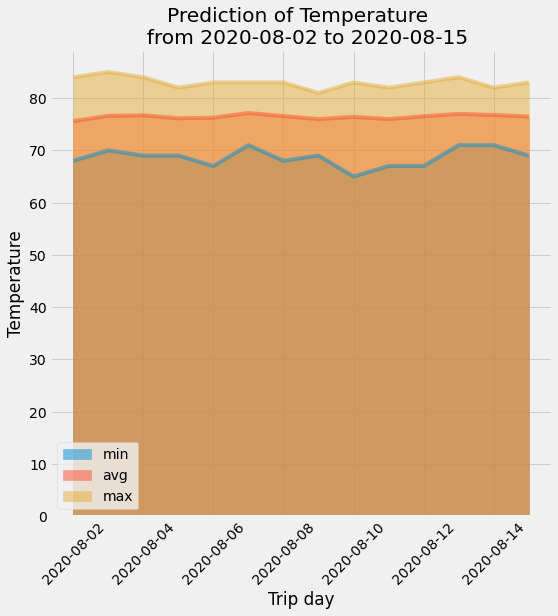

In [33]:
# Plot the daily normals as an area plot with `stacked=False`
Trip_daily_df.plot.area(stacked=False,rot=45,figsize=(8,8))
plt.xlabel("Trip day")
plt.ylabel("Temperature")
plt.title(f"Prediction of Temperature \n  from {Start_Date} to {End_Date}");